##6.5. Rerank using XGB Ranker

We will rerank the 30 candidates for each session using the XGB Ranker, and select the top 20. This is first fitted on the train set and then predicted for the test set. Cross validation using GroupKFold, meaning that data is split according to users rather than simply the number of rows. This prevents any particular user to be in both train and validation data, resulting in leakage and overfitting.

We will do so for Orders only.

As the cross validation is more resource intensive, we will use GPU and Rapids.

In [ ]:
# Run this to check if GPU is used
!nvidia-smi

Sat Apr 22 13:33:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Run this each time to get the RAPIDS-Colab install files and test check GPU
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 385 (delta 86), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (385/385), 105.74 KiB | 8.81 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.8 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a NVIDIA A100-SXM4-40GB!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GroupKFold

import cudf

In [ ]:
cudf.set_option("default_integer_bitwidth", 32)
cudf.set_option("default_float_bitwidth", 32)

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/0.capstone/deploy/train_deploy.parquet')

In [ ]:
train.head()

,session,aid,buy_rank,session_total_interactions,session_unique_aids,session_length,order_aid_unique_sessions,order_aid_total_interactions,cart_aid_unique_sessions,cart_aid_total_interactions,pair_count,pair_count_2,order_num_recurring_aids,cart_num_recurring_aids,last_cart,last_click,cart_order_interaction_ratio,type,ground_truth
0,11098528,11830,1.000000,1,1,0.0,1195.0,1377.0,3294.0,4438.0,30.0,30.0,NaN,NaN,NaN,NaN,3.222948,2.0,1
1,11098528,1732105,0.500000,1,1,0.0,565.0,654.0,1597.0,2268.0,30.0,30.0,NaN,NaN,NaN,NaN,3.467890,NaN,0
2,11098528,588923,0.333333,1,1,0.0,687.0,795.0,1671.0,2114.0,30.0,30.0,NaN,NaN,NaN,1.0,2.659119,NaN,0
3,11098528,884502,0.250000,1,1,0.0,1032.0,1183.0,2352.0,3003.0,30.0,30.0,NaN,NaN,NaN,NaN,2.538462,NaN,0
4,11098528,876129,0.200000,1,1,0.0,840.0,944.0,1816.0,2211.0,30.0,30.0,NaN,NaN,NaN,NaN,2.342161,NaN,0


In [ ]:
feature_cols = train.columns[2:-2]

In [ ]:
def get_session_lengths(df):
    return df.groupby('session')['session'].count().rename('session_length').to_numpy()

session_lengths_train = get_session_lengths(train)

In [ ]:
skf = GroupKFold(n_splits=5)
for fold,(train_idx, valid_idx) in enumerate(skf.split(train, train['ground_truth'], groups=train['session'])):

    X_train = train.loc[train_idx, feature_cols]
    y_train = train.loc[train_idx, 'ground_truth']
    X_valid = train.loc[valid_idx, feature_cols]
    y_valid = train.loc[valid_idx, 'ground_truth']

    # Set group labels based on session lengths
    session_lengths_train = get_session_lengths(train.iloc[train_idx])
    session_lengths_valid = get_session_lengths(train.iloc[valid_idx])

    dtrain = xgb.DMatrix(X_train, y_train, group=session_lengths_train)
    dvalid = xgb.DMatrix(X_valid, y_valid, group=session_lengths_valid)

    xgb_parms = {'objective':'rank:ndcg', 'tree_method':'gpu_hist'} # ndcg is a form of listwise ranking metric
    model = xgb.train(xgb_parms, 
        dtrain=dtrain,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        num_boost_round=1000,
        verbose_eval=100)
    model.save_model(f'/content/drive/MyDrive/0.capstone/deploy/XGB_fold{fold}_order_1.xgb')

[0]	train-map:0.98918	valid-map:0.98928
[100]	train-map:0.99078	valid-map:0.99038
[200]	train-map:0.99137	valid-map:0.99031
[300]	train-map:0.99180	valid-map:0.99019
[400]	train-map:0.99218	valid-map:0.99012
[500]	train-map:0.99243	valid-map:0.99012
[600]	train-map:0.99280	valid-map:0.99005
[700]	train-map:0.99305	valid-map:0.98996
[800]	train-map:0.99328	valid-map:0.98990
[900]	train-map:0.99351	valid-map:0.98984
[999]	train-map:0.99371	valid-map:0.98980
[0]	train-map:0.98922	valid-map:0.98910
[100]	train-map:0.99084	valid-map:0.99018
[200]	train-map:0.99143	valid-map:0.99023
[300]	train-map:0.99185	valid-map:0.99014
[400]	train-map:0.99220	valid-map:0.99005
[500]	train-map:0.99249	valid-map:0.99001
[600]	train-map:0.99285	valid-map:0.98993
[700]	train-map:0.99310	valid-map:0.98987
[800]	train-map:0.99336	valid-map:0.98983
[900]	train-map:0.99358	valid-map:0.98976
[999]	train-map:0.99380	valid-map:0.98977
[0]	train-map:0.98911	valid-map:0.98903
[100]	train-map:0.99082	valid-map:0.9902

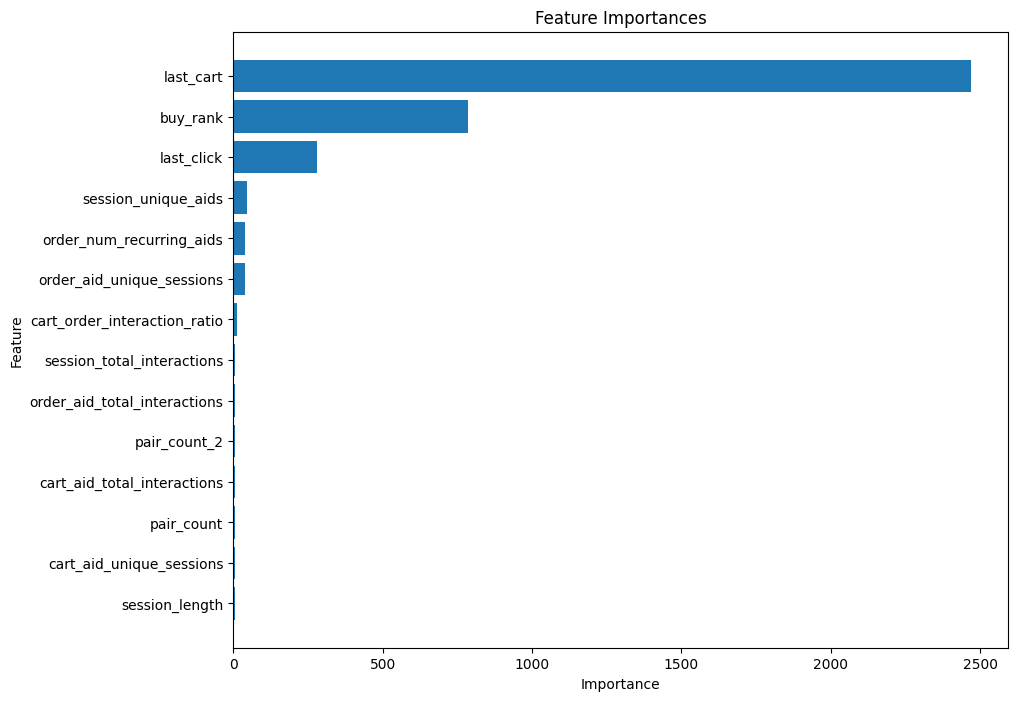

In [ ]:
# Initialize list to store feature importances across all folds
all_importances = []

# Loop over folds
for fold in range(5):
    # Load the trained model
    model = xgb.Booster()
    model.load_model(f'/content/drive/MyDrive/0.capstone/deploy/XGB_fold{fold}_order_1.xgb')

    # Get the feature importances
    importance = model.get_score(importance_type='gain')

    # Append the feature importances to the list
    all_importances.append(importance)

# Merge the dictionaries to obtain the total importance for each feature
merged_importances = {}
for importance in all_importances:
    for feature, score in importance.items():
        if feature in merged_importances:
            merged_importances[feature] += score
        else:
            merged_importances[feature] = score

# Create list of tuples with feature names and importances
feature_importances_list = list(merged_importances.items())

# Sort list by importance
sorted_feature_importances_list = sorted(feature_importances_list, key=lambda x: x[1])

# Create list of feature names and importances
feature_cols = X_train.columns.tolist()
feature_names = [feature_cols[int(x[0][1:])] for x in sorted_feature_importances_list]
importances = [x[1] for x in sorted_feature_importances_list]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, importances, align='center')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importances');

Feature importance quite similar to that of LGBM ranker, with more weight given to the features with smaller coefficients.

In [ ]:
test_candidates_features = pd.read_parquet('/content/drive/MyDrive/0.capstone/covisit_prepare/reranker_candidates_features_test_5.parquet')

In [ ]:
preds = np.zeros(len(test_candidates_features))
for fold in range(5):
    model = xgb.Booster()
    model.load_model(f'/content/drive/MyDrive/0.capstone/deploy/XGB_fold{fold}_order_1.xgb')
    model.set_param({'predictor': 'gpu_predictor'})
    dtest = xgb.DMatrix(data=test_candidates_features[feature_cols])
    preds += model.predict(dtest)/5
predictions = test_candidates_features[['session','aid']].copy()
predictions['pred'] = preds

predictions = predictions.sort_values(['session','pred'], ascending=[True,False]).reset_index(drop=True)
predictions['n'] = predictions.groupby('session').aid.cumcount().astype('int8')
predictions = predictions.loc[predictions.n<20]
sub = predictions.groupby('session').aid.apply(list)
sub = sub.to_frame().reset_index()
sub.item = sub.aid.apply(lambda x: " ".join(map(str,x)))
sub.columns = ['session_type','labels']
sub.session_type = sub.session_type.astype('str')+ '_orders'

<ipython-input-16-d48428677a65>:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub.item = sub.aid.apply(lambda x: " ".join(map(str,x)))


In [ ]:
sub.to_parquet('/content/drive/MyDrive/0.capstone/for_submission/reranker_xgb_3.parquet', index=False)
sub.head()

,session_type,labels
0,12899779_orders,"[397451, 731692, 277075, 1790770, 273918, 1640..."
1,12899780_orders,"[1142000, 736515, 973453, 582732, 209046, 4096..."
2,12899781_orders,"[199008, 918667, 194067, 57315, 141736, 3542, ..."
3,12899782_orders,"[740494, 779477, 834354, 987399, 889671, 12740..."
4,12899783_orders,"[1817895, 607638, 1754419, 198385, 1216820, 17..."


**Results** <br>
Kaggle score (Orders only): 0.27885 <br>
Including rule-based click and cart scores, the overall score is: 0.45841. <br>
Performed much worse than LGBM Ranker and Rules-Based Ranker, probably due to more overfitting. This is surprising because there is GroupKFold cross-validation done here.

As further investigation and improvement relies on paid GPU resources, and the results are quite far off, we will just focus on earlier models rather than fine-tune features and hyperparameters.